# Score vs Pathwise Gradient

In [1]:
from blackbirds.models.sir import SIR
from blackbirds.calibrator import Calibrator

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx
import pygtc
import normflows as nf

In [2]:
n_agents = 1000
graph = networkx.watts_strogatz_graph(n_agents, 10, 0.1)
sir = SIR(graph, n_timesteps=100)

In [3]:
true_parameters = torch.tensor([0.05, 0.05, 0.05]).log10()
true_data = sir.observe(sir.run(true_parameters))

In [4]:
prior = torch.distributions.MultivariateNormal(-2.0 * torch.ones(3), torch.eye(3))

In [5]:
def setup_flow():
    K = 4
    torch.manual_seed(0)
    
    latent_size = 3
    hidden_units = 64
    hidden_layers = 2
    
    flows = []
    for i in range(K):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
        flows += [nf.flows.LULinearPermute(latent_size)]
    
    # Set prior and q0
    q0 = nf.distributions.DiagGaussian(3, trainable=False)
        
    # Construct flow model
    flow = nf.NormalizingFlow(q0=q0, flows=flows)
    return flow

In [6]:
def train_estimator(gradient_estimation_mode, n_samples_per_epoch):
    posterior_estimator = setup_flow() 
    optimizer = torch.optim.Adam(posterior_estimator.parameters(), 1e-3)
    calibrator = Calibrator(model = sir, 
                            posterior_estimator=posterior_estimator, 
                            prior=prior, 
                            data=true_data, 
                            optimizer=optimizer,
                            w = 0.0, 
                            n_samples_per_epoch=n_samples_per_epoch,
                            gradient_estimation_method=gradient_estimation_mode,
                   )
    calibrator.run(250, max_epochs_without_improvement=np.inf)
    return calibrator

In [7]:
%%time
calibrator_pathwise = train_estimator("pathwise", 5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [05:31<00:00,  1.33s/it, Forecast=1.38e+3, Reg.=0, total=1.38e+3, best loss=907, epochs since improv.=19]

CPU times: user 5min 19s, sys: 41.1 s, total: 6min
Wall time: 5min 31s


In [8]:
%%time
calibrator_score = train_estimator("score", 5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s, Forecast=1.75e+5, Reg.=0, total=1.75e+5, best loss=2.27e+4, epochs since improv.=199]

CPU times: user 1min 16s, sys: 36.6 s, total: 1min 52s
Wall time: 1min 24s


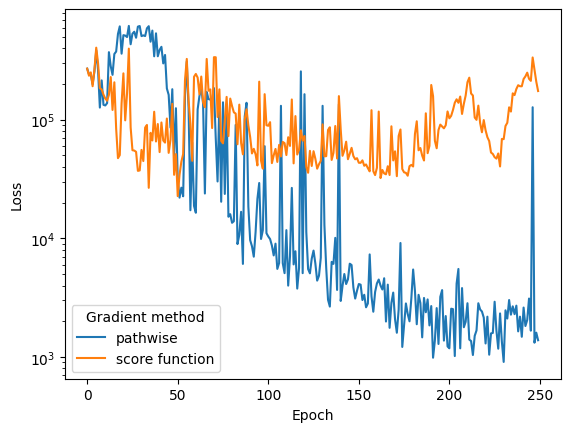

In [9]:
f, ax = plt.subplots()
ax.plot(calibrator_pathwise.losses_hist["total"], label = "pathwise")
ax.plot(calibrator_score.losses_hist["total"], label = "score function")
ax.set_yscale("log")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend(title="Gradient method")

In [10]:
calibrator_pathwise.posterior_estimator.load_state_dict(calibrator_pathwise.best_model_state_dict)
calibrator_score.posterior_estimator.load_state_dict(calibrator_score.best_model_state_dict)

<All keys matched successfully>

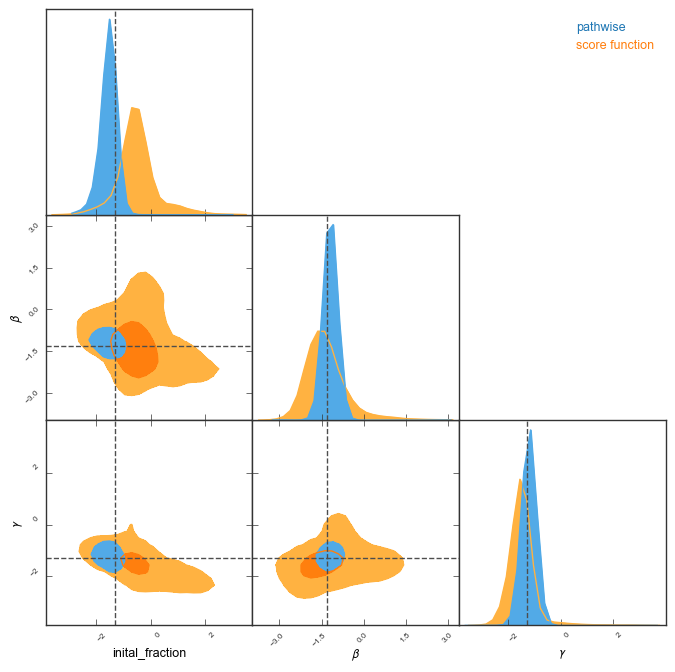

In [11]:
samples_pw = calibrator_pathwise.posterior_estimator.sample(10000)[0].detach().numpy()
samples_score = calibrator_score.posterior_estimator.sample(10000)[0].detach().numpy()

pygtc.plotGTC(chains=[samples_pw, samples_score], figureSize=8, truths = true_parameters.numpy(), chainLabels=["pathwise", "score function"], paramNames=["inital_fraction", r"$\beta$", r"$\gamma$"]);

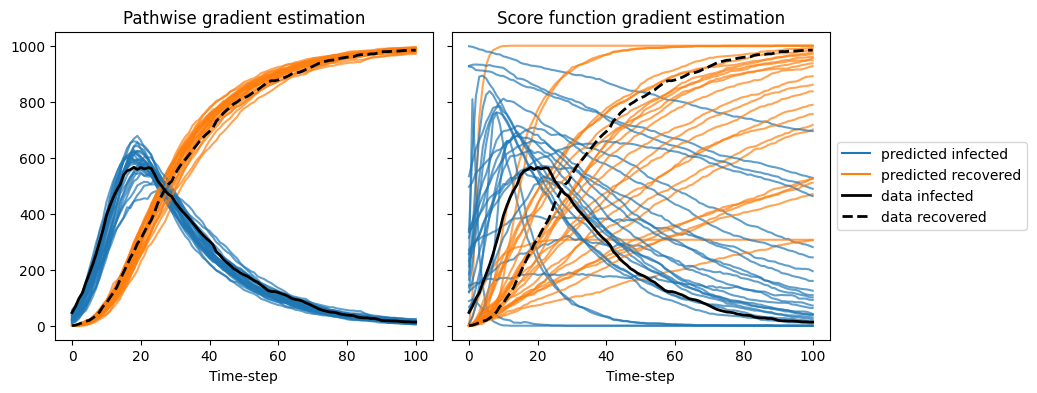

In [14]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
alpha=0.7

for i in range(25):
    with torch.no_grad():
        sim_sir_pw = sir.run_and_observe(calibrator_pathwise.posterior_estimator.sample(1)[0][0])
        ax[0].plot(sim_sir_pw[0].numpy(), color = "C0", alpha=alpha)
        ax[0].plot(sim_sir_pw[1].numpy(), color = "C1", alpha=alpha)
        sim_sir_score = sir.run_and_observe(calibrator_score.posterior_estimator.sample(1)[0][0])
        ax[1].plot(sim_sir_score[0].numpy(), color = "C0", alpha=alpha)
        ax[1].plot(sim_sir_score[1].numpy(), color = "C1", alpha=alpha)
    
ax[1].plot([], [], color = "C0", label = "predicted infected")
ax[1].plot([], [], color = "C1", label = "predicted recovered")
for i in range(2):
    ax[i].plot(true_data[0], color = "black", linewidth=2, label = "data infected")
    ax[i].plot(true_data[1], color = "black", linewidth=2, label = "data recovered", linestyle="--")
    ax[i].set_xlabel("Time-step")

ax[0].set_title("Pathwise gradient estimation")
ax[1].set_title("Score function gradient estimation")

ax[1].legend(loc="center left", bbox_to_anchor=(1,0.5))
plt.subplots_adjust(wspace=0.05, hspace=0.05)